In [ ]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import pandas as pd
import shap
from flaml import AutoML
from xgboost import XGBClassifier

from util import engineer_features, prep_X_y

DATA_DIR = Path("./pistachio_1_data")
dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")

sorted_dyads_df = dyads_df.sort_values(
    by="ActivityDateTime", key=lambda x: pd.to_datetime(x)
)
cleaned_dyads_dfs = engineer_features(
    sorted_dyads_df,
    stress_lookback_days=0,
    sleep_days_to_keep=[1, 2],
)

In [79]:
import numpy as np
from tqdm.auto import tqdm

week_range = (0, 15)
active_hours = (7, 20)

supersets_to_test = [
    ["watch"],
    ["watch", "demographic"],
    ["watch", "medical"],
    ["watch", "demographic", "medical"],
]
feature_supersets = {
    "watch": [
        "hr",
        "activity",
        "sleep",
        "stress",
        "overnight_hrv",
    ],
    "demographic": [
        "child_demo",
        "parent_demo",
    ],
    "medical": [
        "medical",
        "therapy",
    ],
}


def bootstrap(df: pd.DataFrame, n_samples: int) -> pd.DataFrame:
    boot_df = pd.DataFrame()
    for _ in range(n_samples):
        boot_df = pd.concat(
            [
                boot_df,
                df.sample(frac=1, replace=True, random_state=None),
            ]
        )
    return boot_df


def do_shap_analysis(supersets: list[str], week: int):
    df = pd.concat(
        [
            cleaned_dyads_dfs["index"],
            cleaned_dyads_dfs["response"],
        ]
        + [
            cleaned_dyads_dfs[fs]
            for superset in supersets
            for fs in feature_supersets[superset]
        ],
        axis=1,
    )
    df = df[df["therapy_week"].between(week_range[0], week_range[1])]
    df = df[df["ActivityDateTime"].dt.hour.between(active_hours[0], active_hours[1])]

    df_population = df[df["Arm_Sham"]]
    df_test = df[~df["Arm_Sham"]]

    automl = AutoML()
    automl_settings = {
        "time_budget": 15,  # seconds
        "estimator_list": ["xgboost"],
        "eval_method": "cv",
        "split_type": "group",
        "groups": df_population["dyad"],
        "verbose": 0,
    }

    X_train_init, y_train_init = prep_X_y(df_population, "tantrum_within_60m")
    automl.fit(
        X_train=X_train_init,
        y_train=y_train_init,
        **automl_settings,
    )
    print("Best config:", automl.best_config)

    all_shaps = []
    all_features = []
    base_values = []
    active_dyads = df_test["dyad"].unique()
    for dyad in tqdm(active_dyads):
        dyad_df = df_test[df_test["dyad"] == dyad]
        add_df = dyad_df[dyad_df["therapy_week"] < week]
        add_df = bootstrap(add_df, len(active_dyads))

        df_train = pd.concat([df_population, add_df[add_df["therapy_week"] < week]])
        df_test = dyad_df[dyad_df["therapy_week"] >= week]

        window = "60m"
        X_train, y_train = prep_X_y(df_train, f"tantrum_within_{window}")
        X_test, y_test = prep_X_y(df_test, response_column=f"tantrum_within_{window}")
        if y_train.nunique() < 2 or y_test.nunique() < 2:
            continue  # Skip if only one class present
        model = XGBClassifier(**automl.best_config)
        model.fit(X_train, y_train)

        # # Compute ROC AUC
        # y_pred_proba = model.predict_proba(X_test)[:, 1]
        # roc_auc = roc_auc_score(y_test, y_pred_proba)
        # print(f"ROC AUC: {roc_auc:.4f}")

        # Create SHAP explainer
        explainer = shap.Explainer(model)
        sv = explainer(X_test)
        all_shaps.append(sv.values)  # The SHAP values
        all_features.append(sv.data)  # The actual feature values
        base_values.append(sv.base_values)  # The starting point (expected value)

    aggregated_shaps = np.vstack(all_shaps)
    aggregated_features = np.vstack(all_features)
    aggregated_base = np.concatenate(base_values)

    exp = shap.Explanation(
        values=aggregated_shaps,
        data=aggregated_features,
        base_values=aggregated_base,
        feature_names=X_train_init.columns.tolist(),
    )
    return exp

Best config: {'n_estimators': 5, 'max_leaves': 15, 'min_child_weight': np.float64(0.36051861447735994), 'learning_rate': np.float64(0.016735739166824564), 'subsample': np.float64(0.9313107935818838), 'colsample_bylevel': np.float64(0.5992047362420976), 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': np.float64(8.529699455328494)}


  0%|          | 0/28 [00:00<?, ?it/s]

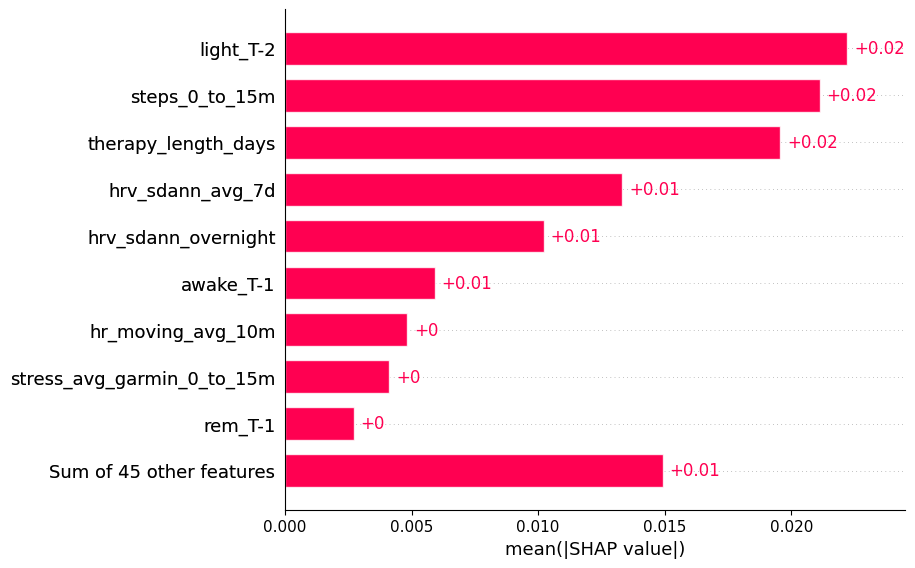

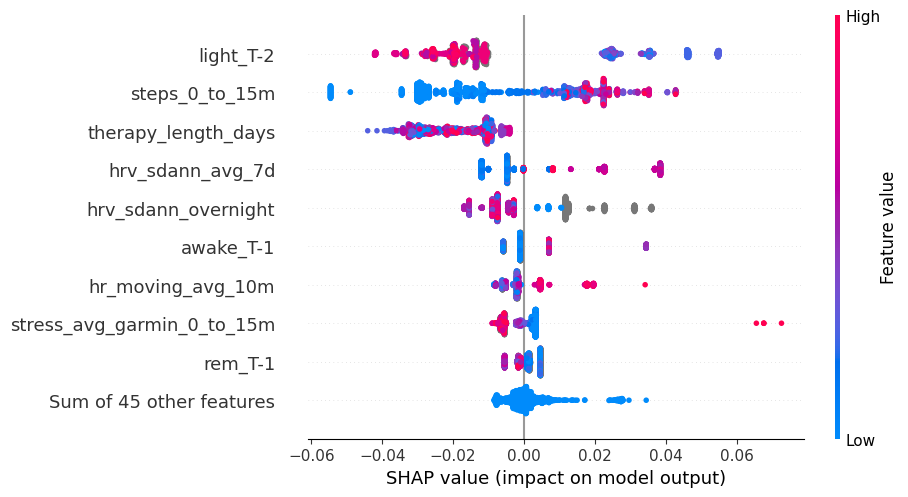

In [80]:
explanation = do_shap_analysis(supersets_to_test[-1], week=8)
shap.plots.bar(explanation)
shap.plots.beeswarm(explanation)